# 毕业论文`GRAD`
## `CMAQ`模拟效果验证

---
*@author: Evan*\
*@date: 2024-04-02*

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

import sys
sys.path.append('../../src/')
from namelist import *
from mask import polygon_to_mask
import ModelEvalLib as me

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

In [2]:
years = [2014, 2015, 2016,2019,2021,2022]
month = 'Sep'

simvar = 'O3'
obsvar = 'O3'

In [7]:
def plot_line_long(year,mean_obs,mean_sim):
    fig = plt.figure(figsize=(24,3),dpi=300)
    ax = fig.subplots(1,1)

    xx = np.arange(0,np.size(mean_obs,0),1)
    ax.plot(xx,mean_sim,color='tab:red',label='SIM',linestyle='-', marker='.',markersize=10)
    ax.plot(xx,mean_obs,color='tab:blue',label='OBS',linestyle='--',marker='.',markersize=10)

    ax.set_xlim([0,np.size(mean_obs,0)-1])
    ax.set_xticks(xx[::24])
    STR = get_STR(year,month)
    END = get_END(year,month)
    ax.set_xticklabels(pd.date_range(STR,END,freq='D').strftime('%m-%d'))#,rotation=45)

    strdict = {'fontsize':16,'fontweight':'bold'}
    strdict2 = dict(fontsize=20,fontweight='bold',)
    ax.set_xlabel('Date',fontdict=strdict)
    ax.set_ylabel('O$_3$ ($\mu$g/m$^3$)',fontdict=strdict)
    if year == 2019 or year == 2014:
        title = '(a)'
    elif year == 2021 or year == 2015:
        title = '(b)'
    elif year == 2022 or year == 2016:
        title = '(c)'
    ax.set_title(title,loc='left',fontdict=strdict2)
    ax.legend(loc=2)

    # ===========
    # add metrics
    # mb_str   = '{:.2f}'.format(mb)
    # r_str    = '{:.2f}'.format(r)
    # rmse_str = '{:.2f}'.format(rmse)

    # ax.text(0.73,1.01,f'R = {r_str}',transform=ax.transAxes,fontdict=strdict,ha='right')
    # ax.text(0.85,1.01,f'MB = {mb_str}',transform=ax.transAxes,fontdict=strdict,ha='right')
    # ax.text(0.99,1.01,f'RMSE = {rmse_str}',transform=ax.transAxes,fontdict=strdict,ha='right')

    plt.savefig(f'D:/Academic/Project/GRAD/Annually/figures/模拟验证/without_metrics/{simvar}_{year}.png',dpi=300,bbox_inches='tight')
    plt.close()

In [5]:
def print_metrics(sim,obs):
    metrics = me.CalculateMetrics(obs,sim)
    mb   = metrics.get_mb().values
    r    = metrics.get_r()
    rmse = metrics.get_rmse().values
    ioa  = metrics.get_ioa().values
    nmb  = metrics.get_nmb().values
    nme  = metrics.get_nme().values
    print('MB  : ',mb,'\nR   : ',r,'\nRMSE: ',rmse,'\nIOA : ',ioa,'\nNMB : ',nmb,'\nNME : ',nme)
    

In [11]:
for year in years:
    print(f'Year = {year}')

    # Simulation data
    ds = xr.open_dataset(datadir + f'processed/{month}_{year}/{month}_{year}_chem.nc')
    data_sim = ds[simvar][:,0,:,:]
    shp = gpd.read_file(shp_files['PRD_merge_adm'])
    lon = data_sim.longitude
    lat = data_sim.latitude
    mask    = polygon_to_mask(shp.geometry[0], lon, lat)
    mask_da = xr.DataArray(mask, dims=('y','x'))
    masked_sim  = data_sim.where(mask_da)
    mean_sim    = masked_sim.mean(dim=('x','y'),skipna=True)
    sim = mean_sim.rolling(time=8).mean().resample(time='D').max()
    
    # Observation data
    obspath = get_obspath(month)
    df = pd.read_excel(obspath + f'site_{obsvar}_{year}.xlsx',index_col=0)
    mean_obs = df.mean(axis=1,skipna=True)
    
    # 使用逐小时值计算统计量，观测序列需对空值做填充
    inteobs = mean_obs.interpolate(method='linear')
    obs = inteobs.rolling(8).mean().resample('D').max()
    
    print('-'*5+'Hour'+'-'*5)
    print_metrics(mean_sim,inteobs)
    print('-'*5+'MDA8'+'-'*5)
    print_metrics(sim,obs)
    
    sim90 = sim.quantile(0.9).values
    obs90 = obs.quantile(0.9)
    mb90 = sim90 - obs90
    print(f'MDA8 90per  :  {mb90}')
    plot_line_long(year,mean_obs,mean_sim)
    print('='*20)
    
    

Year = 2014
-----Hour-----
MB  :  30.182362178627834 
R   :  0.867348835572018 
RMSE:  37.878122374545946 
IOA :  0.8342229251515998 
NMB :  48.69981564915557 
NME :  61.1170711510031
-----MDA8-----
MB  :  25.319479491920514 
R   :  0.824114831920096 
RMSE:  33.838942291447644 
IOA :  0.7542794125279627 
NMB :  22.81749314083103 
NME :  30.49509109673713
MDA8 90per  :  12.857343719860921
Year = 2015
-----Hour-----
MB  :  34.255839625624105 
R   :  0.8428400131458575 
RMSE:  42.38841127132135 
IOA :  0.8043966913160072 
NMB :  49.8634475717607 
NME :  61.7013725594605
-----MDA8-----
MB  :  34.013233080974224 
R   :  0.8418255878534618 
RMSE:  41.24369107764991 
IOA :  0.7012816690951347 
NMB :  30.14484785652022 
NME :  36.552973062490956
MDA8 90per  :  16.384688326171187
Year = 2016
-----Hour-----
MB  :  42.37084054593123 
R   :  0.7450833782384572 
RMSE:  52.453847984022126 
IOA :  0.7053147072457506 
NMB :  64.32804297707787 
NME :  79.6362154716165
-----MDA8-----
MB  :  43.390154249

---

In [3]:
year = 2019
ds = xr.open_dataset(datadir + f'processed/{month}_{year}/{month}_{year}_chem.nc')
data_sim = ds[simvar][:,0,:,:]
shp = gpd.read_file(shp_files['PRD_merge_adm'])
lon = data_sim.longitude
lat = data_sim.latitude
mask    = polygon_to_mask(shp.geometry[0], lon, lat)
mask_da = xr.DataArray(mask, dims=('y','x'))
masked_sim  = data_sim.where(mask_da)
mean_sim    = masked_sim.mean(dim=('x','y'),skipna=True)
sim = mean_sim.rolling(time=8).mean().resample(time='D').max()

# Observation data
obspath = get_obspath(month)
df = pd.read_excel(obspath + f'site_{obsvar}_{year}.xlsx',index_col=0)
mean_obs = df.mean(axis=1,skipna=True)

# 使用逐小时值计算统计量，观测序列需对空值做填充
inteobs = mean_obs.interpolate(method='linear')
obs = inteobs.rolling(8).mean().resample('D').max()


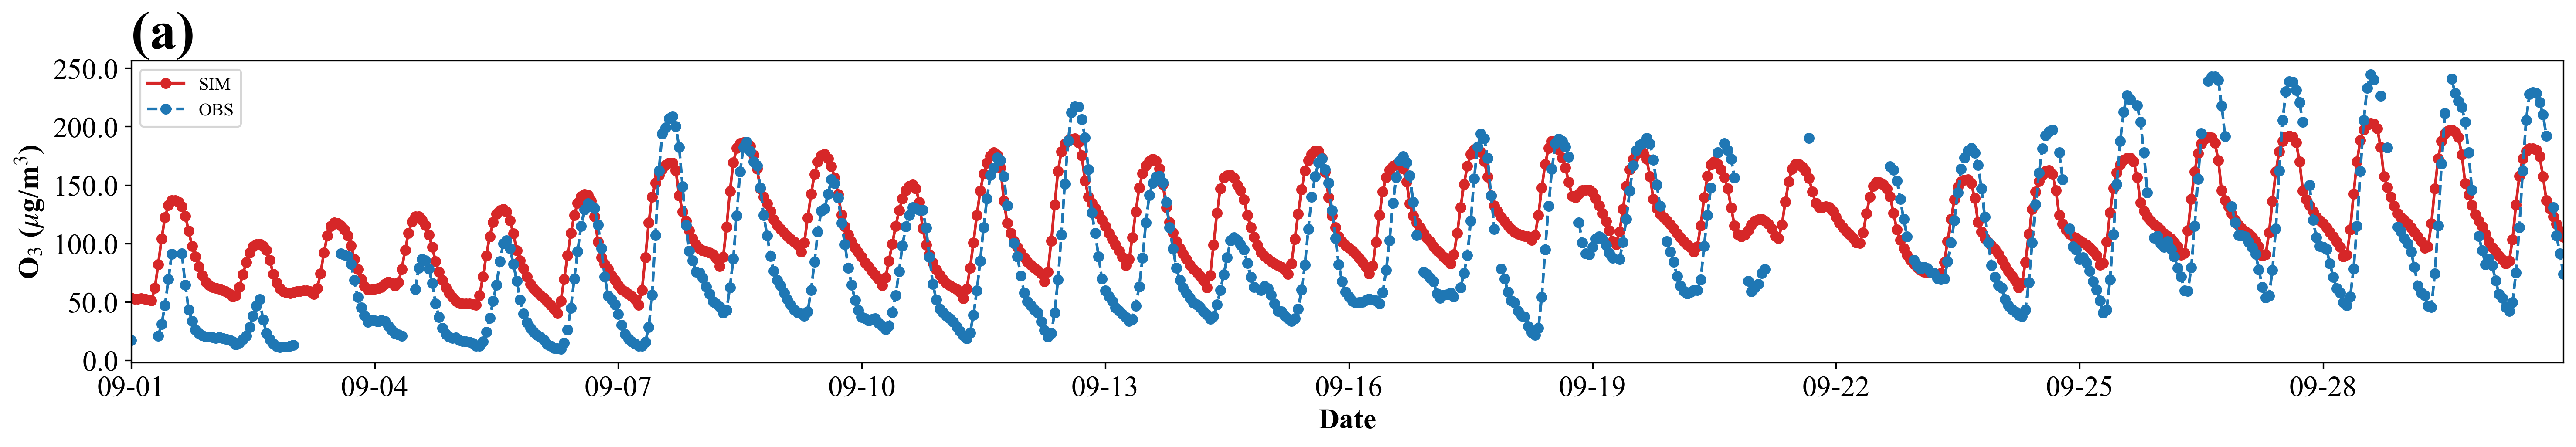

In [9]:
fig = plt.figure(figsize=(24,3),dpi=300)
ax = fig.subplots(1,1)

xx = np.arange(0,np.size(mean_obs,0),1)
ax.plot(xx,mean_sim,color='tab:red',label='SIM',linestyle='-', marker='.',markersize=10)
ax.plot(xx,mean_obs,color='tab:blue',label='OBS',linestyle='--',marker='.',markersize=10)

ax.set_xlim([0,np.size(mean_obs,0)-1])
ax.set_xticks(xx[::24*3])
STR = get_STR(year,month)
END = get_END(year,month)
ax.set_xticklabels(pd.date_range(STR,END,freq='3D').strftime('%m-%d'),fontsize=16)
# ax.tick_params(axis='x',labelsize=16,labelweight='bold')
ax.set_yticklabels(ax.get_yticks(),fontsize=16)
strdict = {'fontsize':16,'fontweight':'bold'}
strdict2 = dict(fontsize=30,fontweight='bold',)
ax.set_xlabel('Date',fontdict=strdict)
ax.set_ylabel('O$_3$ ($\mu$g/m$^3$)',fontdict=strdict)
if year == 2019 or year == 2014:
    title = '(a)'
elif year == 2021 or year == 2015:
    title = '(b)'
elif year == 2022 or year == 2016:
    title = '(c)'
ax.set_title(title,loc='left',fontdict=strdict2)
ax.legend(loc=2)
plt.show()

---

# 放到一张图

In [10]:
sim = {}
obs = {}
for year in years:
    ds = xr.open_dataset(datadir + f'processed/{month}_{year}/{month}_{year}_chem.nc')
    data_sim = ds[simvar][:,0,:,:]
    shp = gpd.read_file(shp_files['PRD_merge_adm'])
    lon = data_sim.longitude
    lat = data_sim.latitude
    mask    = polygon_to_mask(shp.geometry[0], lon, lat)
    mask_da = xr.DataArray(mask, dims=('y','x'))
    masked_sim  = data_sim.where(mask_da)
    mean_sim    = masked_sim.mean(dim=('x','y'),skipna=True)

    # Observation data
    obspath = get_obspath(month)
    df = pd.read_excel(obspath + f'site_{obsvar}_{year}.xlsx',index_col=0)
    mean_obs = df.mean(axis=1,skipna=True)
    
    sim[year] = mean_sim
    obs[year] = mean_obs


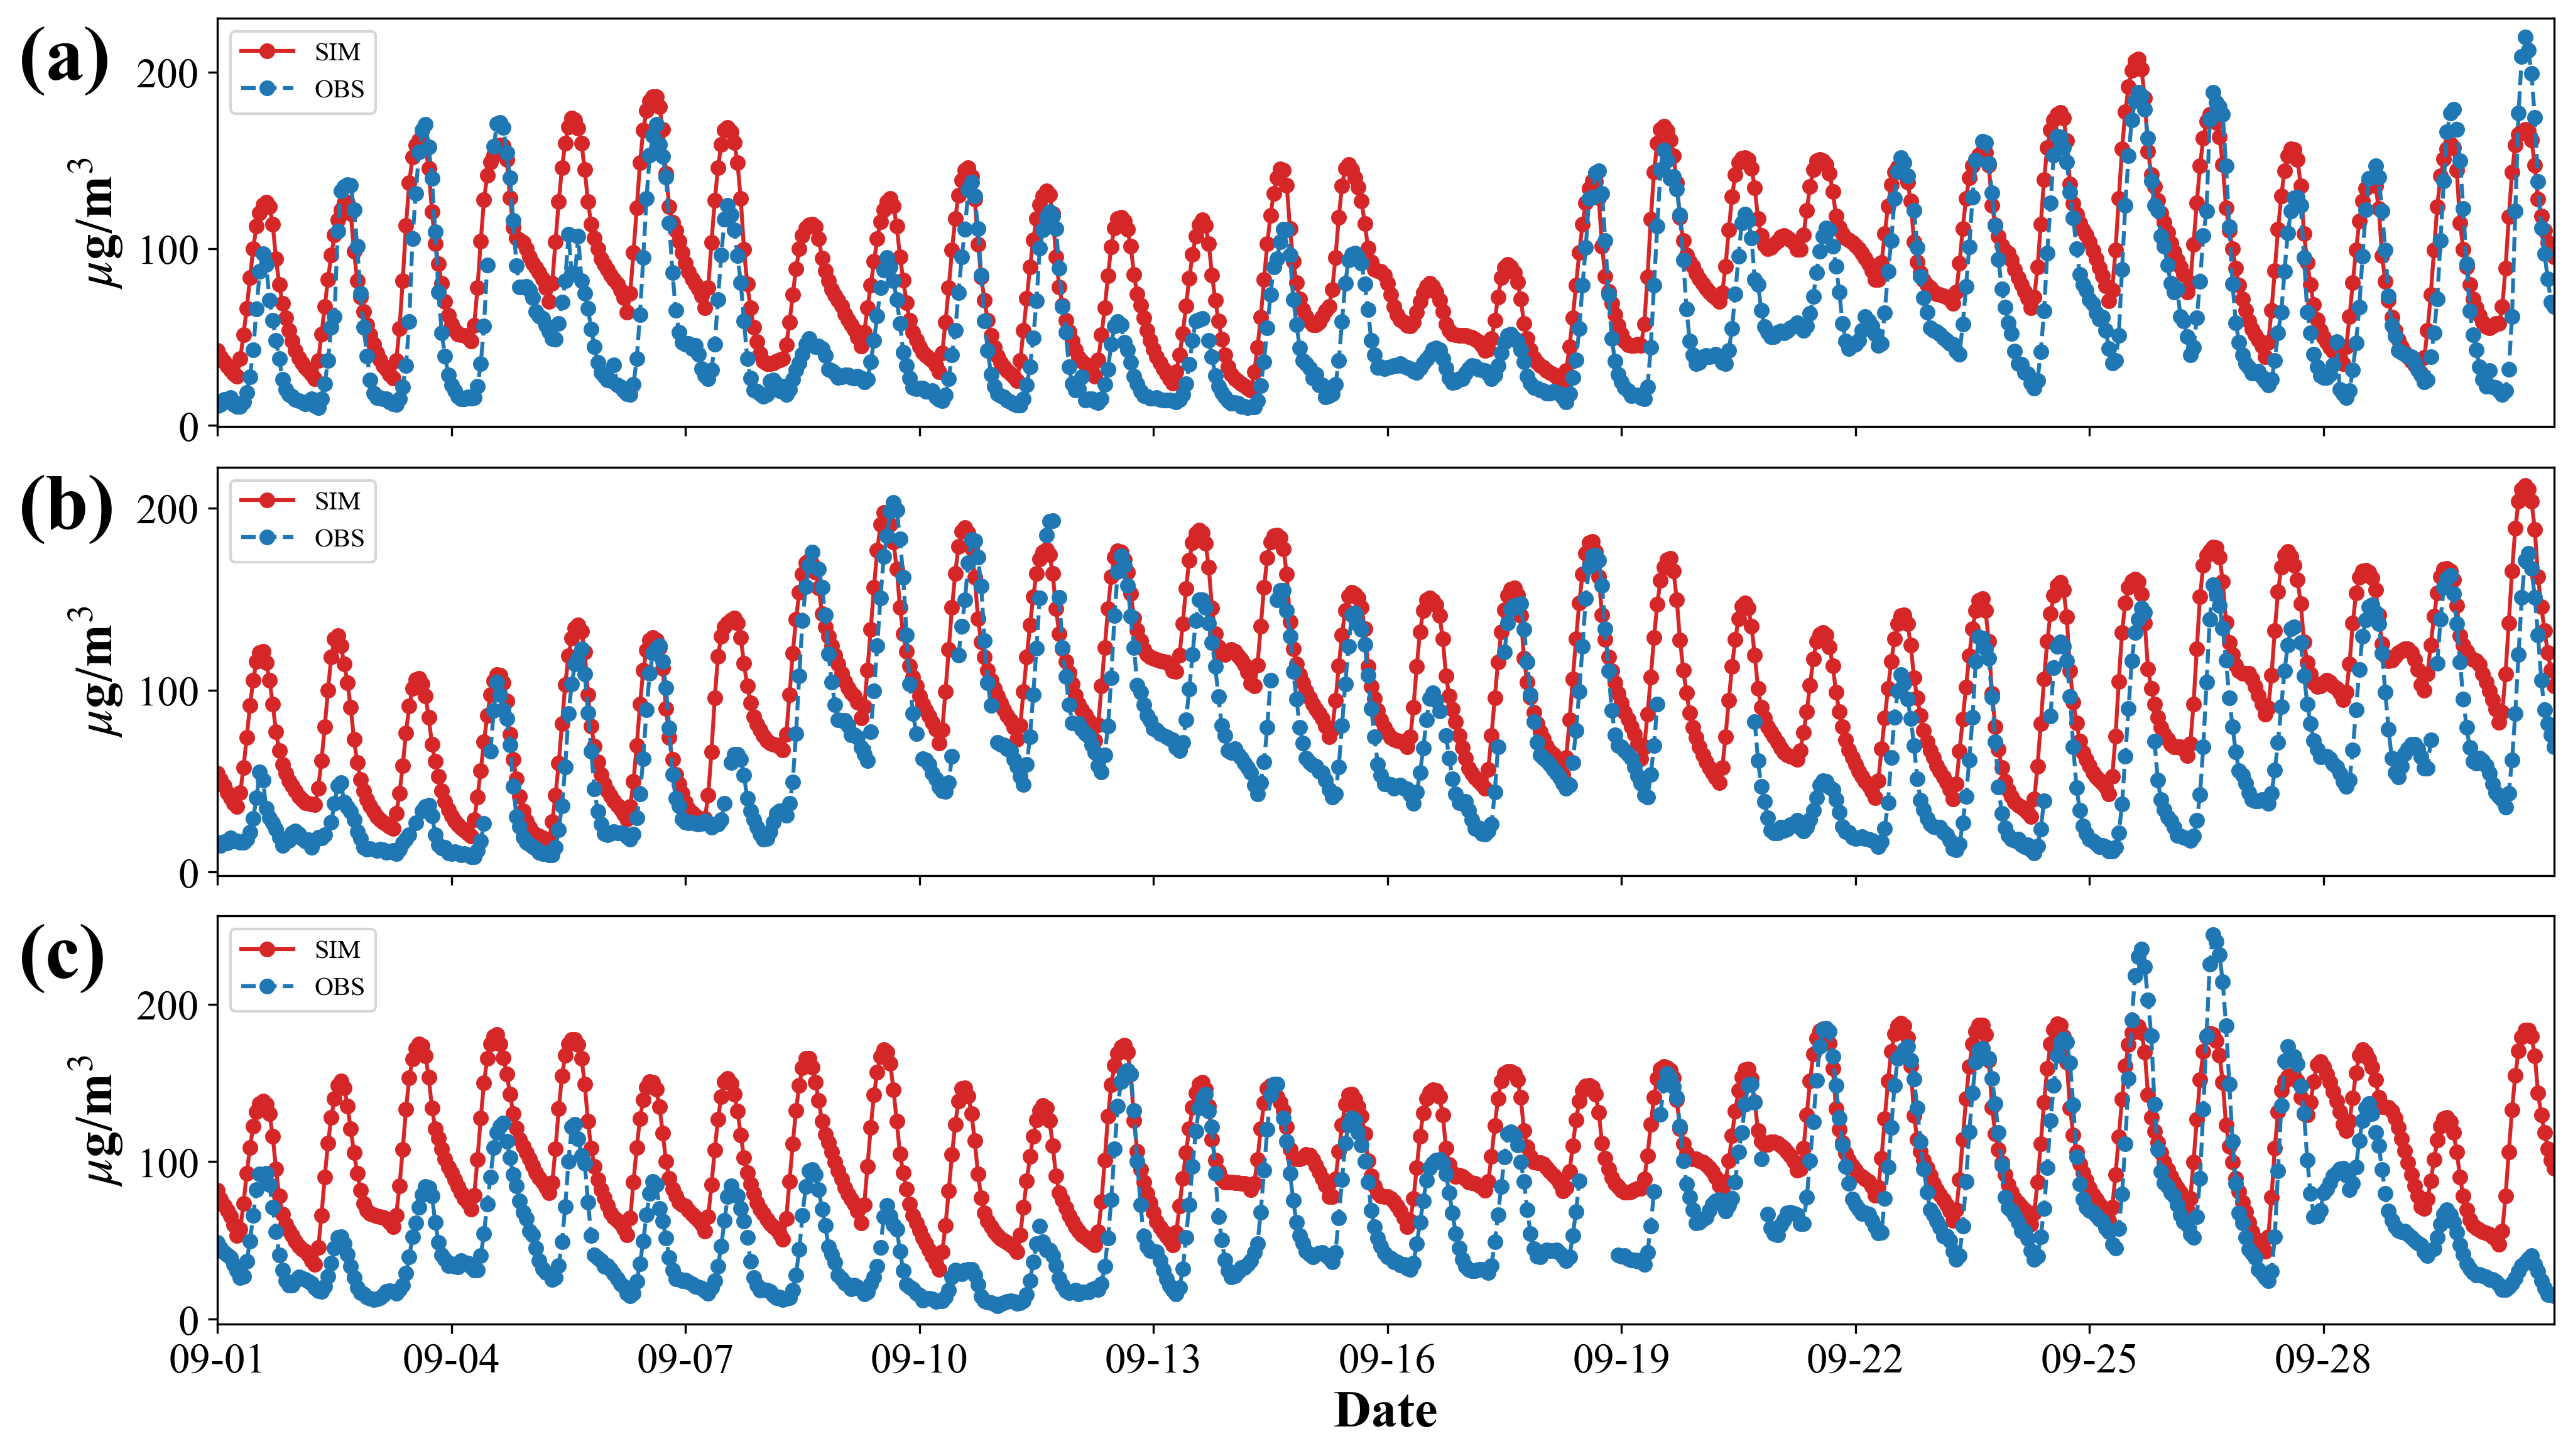

In [52]:
strdict = {'fontsize':20,'fontweight':'bold'}
strdict2 = dict(fontsize=30,fontweight='bold',)
titles = ['(a)','(b)','(c)']

fig = plt.figure(figsize=(16,9),dpi=300)
ax = fig.subplots(3,1)

xx = np.arange(0,np.size(mean_obs,0),1)

for i,year in enumerate(years[:3]):
    ax[i].plot(xx,sim[year],color='tab:red',label='SIM',linestyle='-', marker='.',markersize=10)
    ax[i].plot(xx,obs[year],color='tab:blue',label='OBS',linestyle='--',marker='.',markersize=10)

    ax[i].set_xlim([0,np.size(mean_obs,0)-1])
    ax[i].set_xticks(xx[::24*3])
    STR = get_STR(year,month)
    END = get_END(year,month)
    # ax[i].set_yticklabels(ax[i].get_yticks(),fontsize=16)
    ax[i].tick_params(axis='y',labelsize=16)
    if i ==2:
        ax[i].set_xticklabels(pd.date_range(STR,END,freq='3D').strftime('%m-%d'),fontsize=16)
        ax[i].set_xlabel('Date',fontdict=strdict)
    else:
        ax[i].set_xticklabels('')
        ax[i].set_xlabel('')
    ax[i].set_ylabel('$\mu$g/m$^3$',fontdict=strdict)

    ax[i].text(-0.085,0.85,titles[i],transform=ax[i].transAxes,fontdict=strdict2)
    ax[i].legend(loc=2)
plt.subplots_adjust(hspace=0.1)
plt.show()

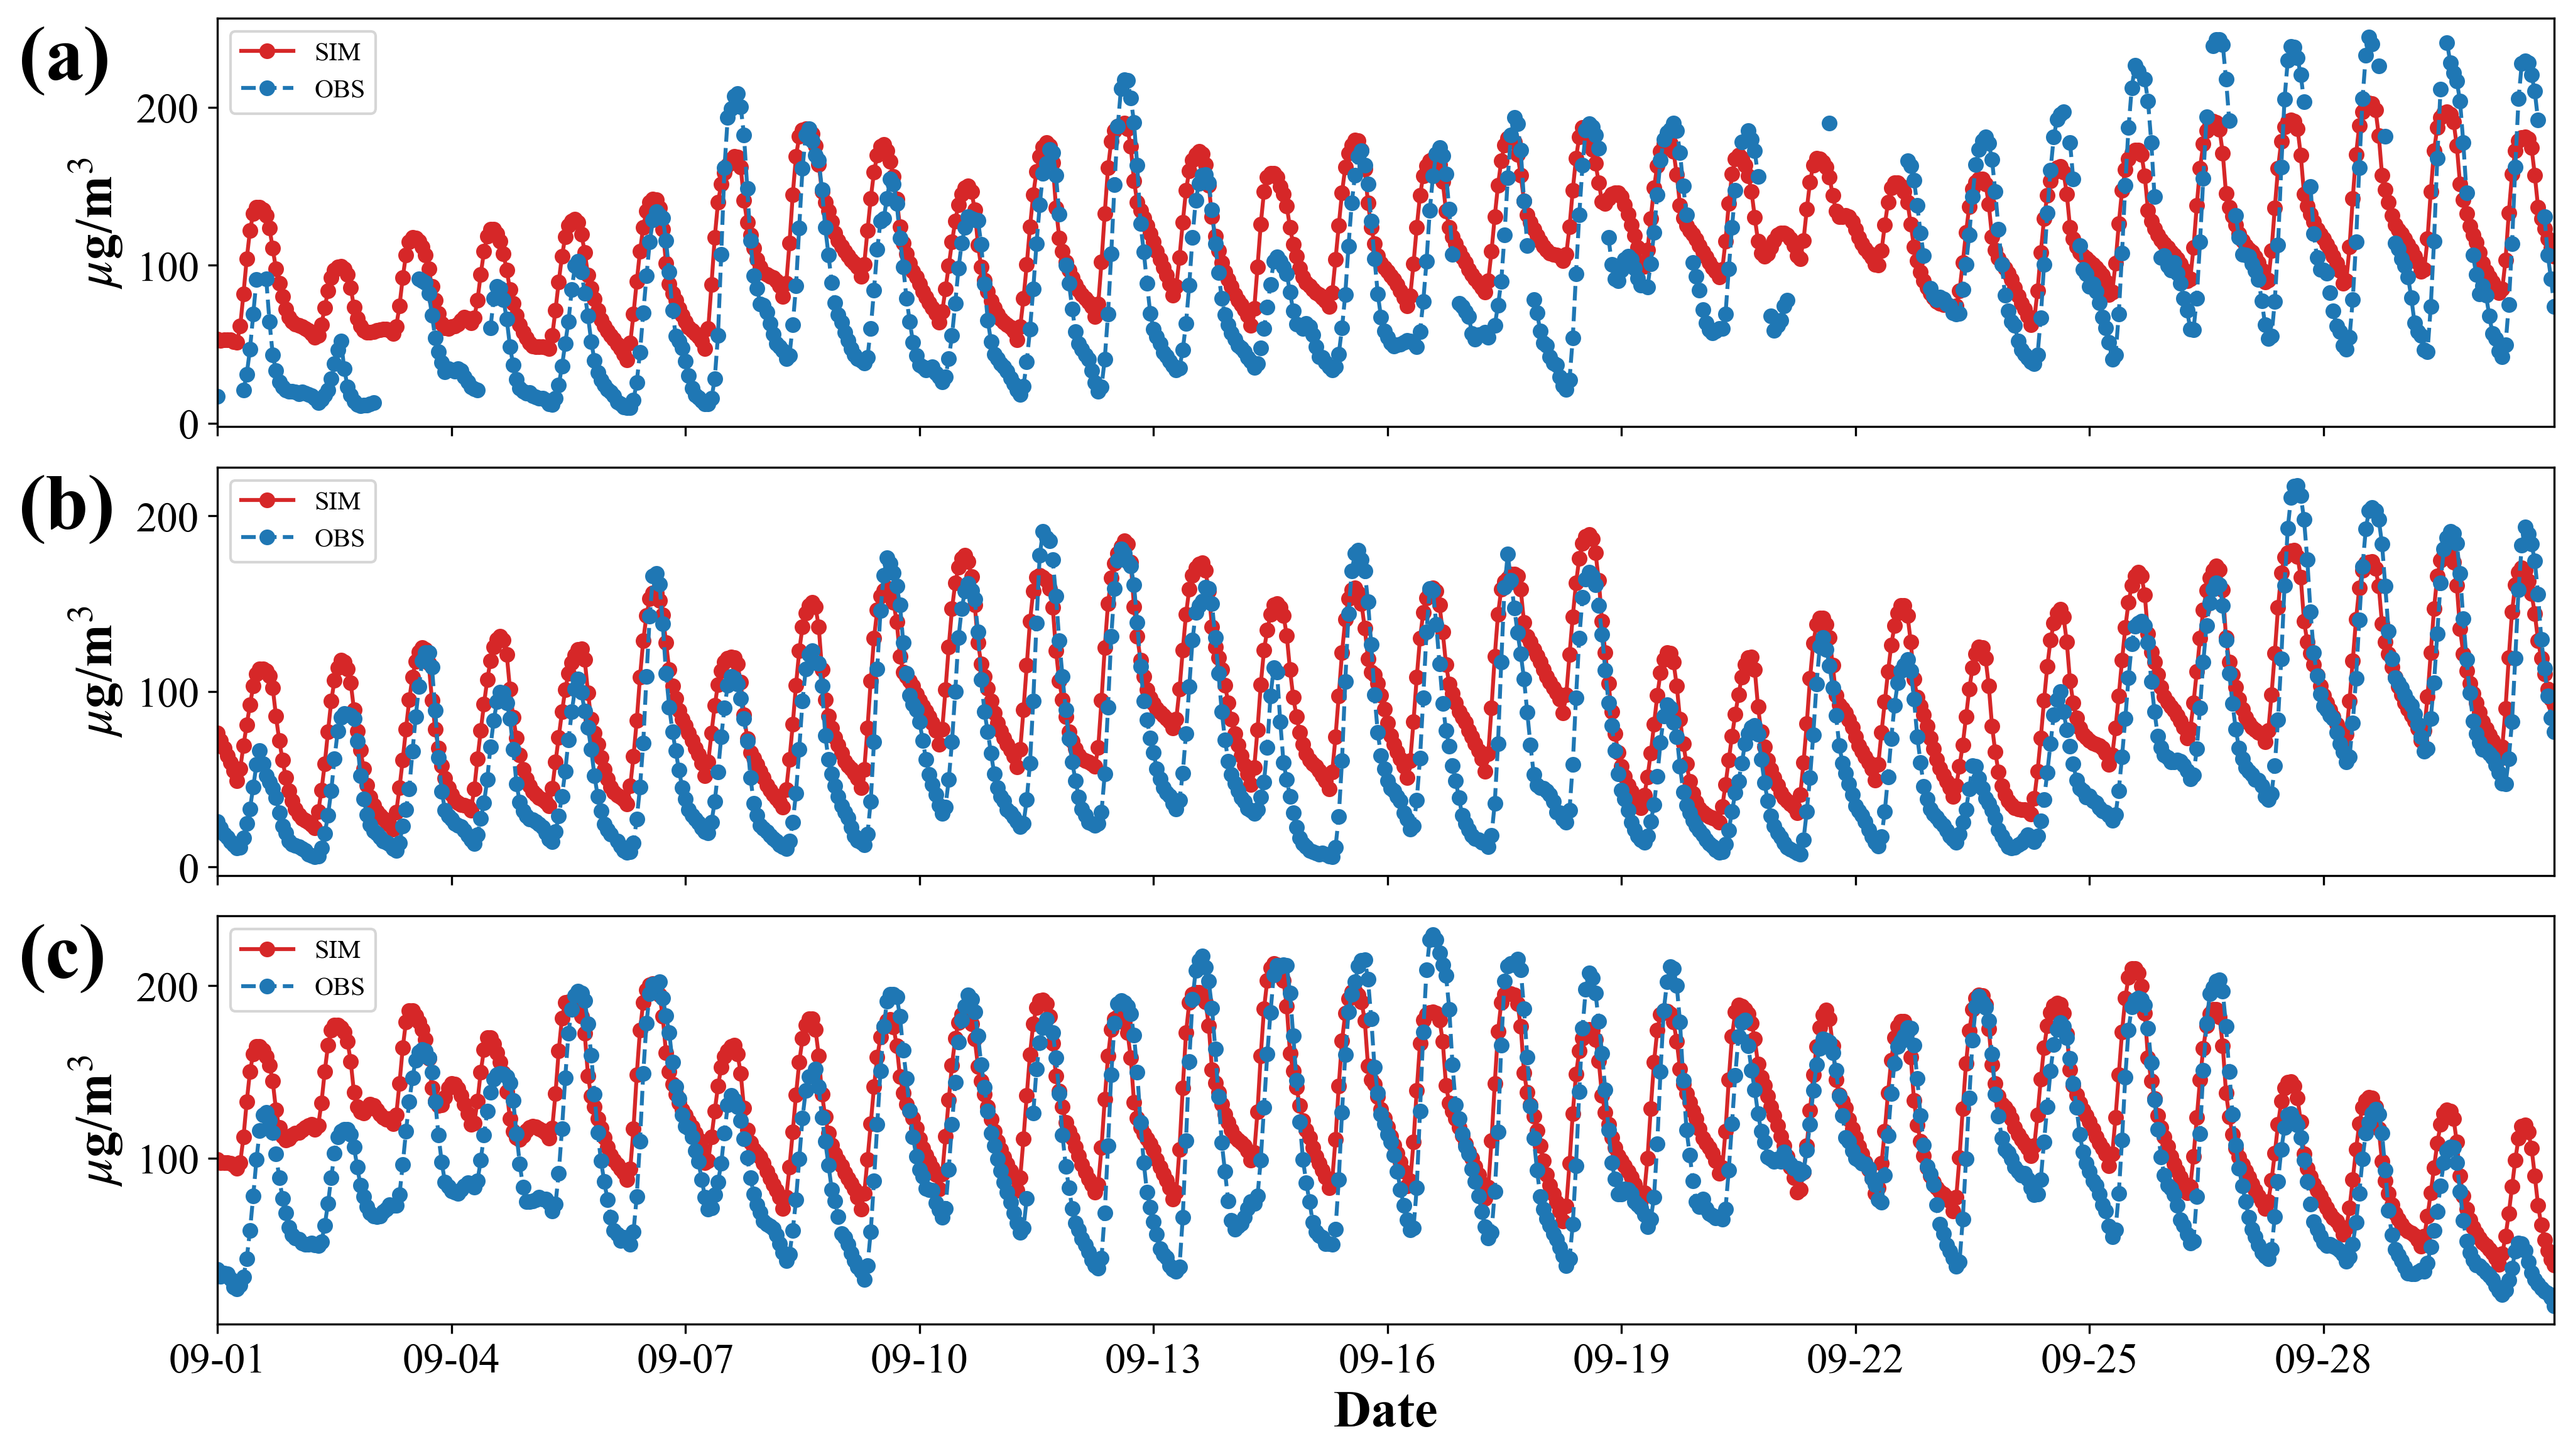

In [53]:
strdict = {'fontsize':20,'fontweight':'bold'}
strdict2 = dict(fontsize=30,fontweight='bold',)
titles = ['(a)','(b)','(c)']

fig = plt.figure(figsize=(16,9),dpi=300)
ax = fig.subplots(3,1)

xx = np.arange(0,np.size(mean_obs,0),1)

for i,year in enumerate(years[3:]):
    ax[i].plot(xx,sim[year],color='tab:red',label='SIM',linestyle='-', marker='.',markersize=10)
    ax[i].plot(xx,obs[year],color='tab:blue',label='OBS',linestyle='--',marker='.',markersize=10)

    ax[i].set_xlim([0,np.size(mean_obs,0)-1])
    ax[i].set_xticks(xx[::24*3])
    STR = get_STR(year,month)
    END = get_END(year,month)
    # ax[i].set_yticklabels(ax[i].get_yticks(),fontsize=16)
    ax[i].tick_params(axis='y',labelsize=16)
    if i ==2:
        ax[i].set_xticklabels(pd.date_range(STR,END,freq='3D').strftime('%m-%d'),fontsize=16)
        ax[i].set_xlabel('Date',fontdict=strdict)
    else:
        ax[i].set_xticklabels('')
        ax[i].set_xlabel('')
    ax[i].set_ylabel('$\mu$g/m$^3$',fontdict=strdict)

    ax[i].text(-0.085,0.85,titles[i],transform=ax[i].transAxes,fontdict=strdict2)
    ax[i].legend(loc=2)
plt.subplots_adjust(hspace=0.1)
plt.show()